# Craft curves

In [ ]:
from math import cos, pi, sin

import numpy as np
import pandas as pd

np.random.seed(42)

max_size = 500

K1 = [cos(2 * pi / 8 * t) for t in range(max_size)]
K2 = []
for t in range(0, max_size, 8):
    K2 += [0, 2, 1, 2, 0, -2, -1, -2]
K2 = K2[:max_size]

K3 = [0.5 + sin(2 * pi / 7 * t) for t in range(max_size)]

K4 = []
for t in range(0, max_size, 5):
    K4 += [2, 1, 1, 1, 2]
K4 = K4[:max_size]


K5 = [K4[i] * K3[i] + K2[i] - K1[i] for i in range(max_size)]

# Check curves

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, sharex=True)
fig.suptitle("Vertically stacked subplots")
axs[0].plot(K1)
axs[1].plot(K2)
axs[2].plot(K3)
axs[3].plot(K4)
axs[4].plot(K5)

In [ ]:
df = pd.DataFrame(
    {"K1": K1, "K2": K2, "K3": K3, "K4": K4, "K5": K5},
    columns=["K1", "K2", "K3", "K4", "K5"],
    dtype="float32",
)
df.shape

df.describe()

# Define problem

X lives on a weierd planet where males can be feconded only when the Y rate is above 4. Zorg has measured carefully 
all components in the atmosphere and he is looking at predicting the Y rate in 5 & 6 days from now because his 
girlfiriend is living far away.
At a data scientist our role is to help zorg !

We will choose time series of differents size (between 10 & 15) and want to forecast the Y rate.

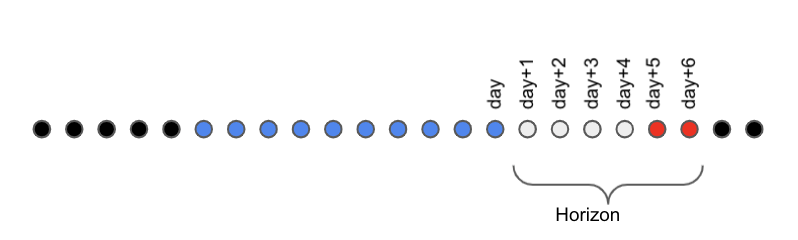

In [ ]:
# Split our dataset in X_train, Xval & X_test

length = int(0.8 * len(df))

horizon = 6

df_train = df.iloc[:length, :]
df_test = df.iloc[length:, :]

# Lest split X_train again

length = int(0.8 * len(df_train))
df_val = df_train.iloc[length:, :]
df_train = df_train.iloc[:length, :]

print(df_train.shape, df_val.shape, df_test.shape)

In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=3, sharex=True, figsize=(25, 8))
fig.suptitle("Vertically stacked subplots")
axs[0, 0].plot(df_train[["K1"]])
axs[0, 1].plot(df_val[["K1"]])
axs[0, 1].yaxis.set_visible(False)
axs[0, 2].plot(df_test[["K1"]])
axs[0, 2].yaxis.set_visible(False)

axs[1, 0].plot(df_train[["K2"]])
axs[1, 1].plot(df_val[["K2"]])
axs[1, 1].yaxis.set_visible(False)
axs[1, 2].plot(df_test[["K2"]])
axs[1, 2].yaxis.set_visible(False)

axs[2, 0].plot(df_train[["K3"]])
axs[2, 1].plot(df_val[["K3"]])
axs[2, 1].yaxis.set_visible(False)
axs[2, 2].plot(df_test[["K3"]])
axs[2, 2].yaxis.set_visible(False)

axs[3, 0].plot(df_train[["K4"]])
axs[3, 1].plot(df_val[["K4"]])
axs[3, 1].yaxis.set_visible(False)
axs[3, 2].plot(df_test[["K4"]])
axs[3, 2].yaxis.set_visible(False)

axs[4, 0].plot(df[["K5"]], ls=":")
axs[4, 0].plot(df_train[["K5"]])
axs[4, 1].plot(df[["K5"]], ls=":")
axs[4, 1].plot(df_val[["K5"]])
axs[4, 1].yaxis.set_visible(False)
axs[4, 2].plot(df[["K5"]], ls=":")
axs[4, 2].plot(df_test[["K5"]])
axs[4, 2].yaxis.set_visible(False)

# Now Let's define some sequences in each of these partitions

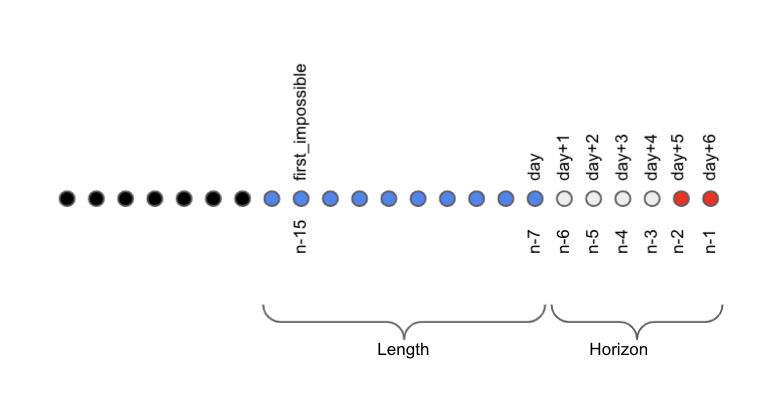

In [ ]:
def get_subsample_sequence(df, length, horizon):
    """
    Given the initial dataframe `df`, return a shorter dataframe sequence of length `length`.
    This shorter sequence should be selected at random.
    """

    first_impossible = df.shape[0] - length - horizon + 1

    random_start = np.random.randint(0, first_impossible)
    df_sample = df[random_start : random_start + length + horizon]

    return df_sample


def split_subsample_sequence(df, length, what_to_predict):
    """Return one single sample (Xi, yi) containing one sequence each of length `length`"""

    horizon = sorted(what_to_predict)[-1]

    df_subsample = get_subsample_sequence(df, length, horizon).copy()

    # Create X_sample
    X_sample = df_subsample.iloc[:length, :]

    # Create y_sample
    y_sample = df_subsample.iloc[[w + length - 1 for w in what_to_predict], :]

    return np.array(X_sample), np.array(y_sample)


def get_X_y(df, sequence_lengths, what_to_predict):
    """Return a dataset (X, y)"""
    X, y = [], []

    for length in sequence_lengths:
        xi, yi = split_subsample_sequence(df, length, what_to_predict)
        X.append(xi)
        y.append(yi)

    return X, np.array(y)

In [ ]:
what_to_predict = [1, 2]

assert 0 not in what_to_predict

horizon = sorted(what_to_predict)[-1]

In [ ]:
sample = get_subsample_sequence(df_train, 10, horizon)
sample

In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=1, sharex=True, figsize=(8, 8))
fig.suptitle("A sample")

axs[0].plot(sample[["K1"]])
axs[1].plot(sample[["K2"]])
axs[2].plot(sample[["K3"]])
axs[3].plot(sample[["K4"]])
axs[4].plot(sample[["K5"]])

In [ ]:
min_seq_len = 10
max_seq_len = 15

padded_value = -5

sequence_lengths_train = np.random.randint(low=min_seq_len, high=max_seq_len, size=100)
X_train, y_train = get_X_y(df_train, sequence_lengths_train, what_to_predict)

sequence_lengths_val = np.random.randint(low=min_seq_len, high=max_seq_len, size=50)
X_val, y_val = get_X_y(df_val, sequence_lengths_val, what_to_predict)

sequence_lengths_test = np.random.randint(low=min_seq_len, high=max_seq_len, size=50)
X_test, y_test = get_X_y(df_test, sequence_lengths_test, what_to_predict)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_pad_post = pad_sequences(
    X_train, value=padded_value, dtype=float, padding="post", maxlen=max_seq_len
)
X_train_pad_pre = pad_sequences(
    X_train, value=padded_value, dtype=float, padding="pre", maxlen=max_seq_len
)

X_val_pad_post = pad_sequences(
    X_val, value=padded_value, dtype=float, padding="post", maxlen=max_seq_len
)
X_val_pad_pre = pad_sequences(
    X_val, value=padded_value, dtype=float, padding="pre", maxlen=max_seq_len
)

X_test_pad_post = pad_sequences(
    X_test, value=padded_value, dtype="float32", padding="post", maxlen=max_seq_len
)
X_test_pad_pre = pad_sequences(
    X_test, value=padded_value, dtype="float32", padding="pre", maxlen=max_seq_len
)

In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=2, sharex=True, figsize=(8, 8))
fig.suptitle("A sample")

i = np.random.randint(len(X_train_pad_post))

the_range = [x + len(X_train_pad_post[i]) - 1 for x in what_to_predict]

axs[0, 0].plot(X_train_pad_post[i][:, 0])
axs[0, 0].scatter(the_range, y_train[i][:, 0])

axs[1, 0].plot(X_train_pad_post[i][:, 1])
axs[1, 0].scatter(the_range, y_train[i][:, 1])

axs[2, 0].plot(X_train_pad_post[i][:, 2])
axs[2, 0].scatter(the_range, y_train[i][:, 2])

axs[3, 0].plot(X_train_pad_post[i][:, 3])
axs[3, 0].scatter(the_range, y_train[i][:, 3])

axs[4, 0].plot(X_train_pad_post[i][:, 4])
axs[4, 0].scatter(the_range, y_train[i][:, 4])

axs[0, 1].plot(X_train_pad_pre[i][:, 0])
axs[0, 1].scatter(the_range, y_train[i][:, 0])

axs[1, 1].plot(X_train_pad_pre[i][:, 1])
axs[1, 1].scatter(the_range, y_train[i][:, 1])

axs[2, 1].plot(X_train_pad_pre[i][:, 2])
axs[2, 1].scatter(the_range, y_train[i][:, 2])

axs[3, 1].plot(X_train_pad_pre[i][:, 3])
axs[3, 1].scatter(the_range, y_train[i][:, 3])

axs[4, 1].plot(X_train_pad_pre[i][:, 4])
axs[4, 1].scatter(the_range, y_train[i][:, 4])

# Create an LSTM model

## Using xxx API

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import RMSprop


def init_model(mask_value=-1000):

    model = models.Sequential()
    model.add(
        layers.Masking(mask_value=mask_value, input_shape=X_train_pad_pre.shape[1:])
    )
    model.add(layers.LSTM(20, activation="tanh"))
    model.add(layers.Dense(10, activation="relu"))
    model.add(layers.Dense(y_train.shape[1], activation="linear"))

    model.compile(loss="mse", optimizer=RMSprop(), metrics=["mae"])

    return model


init_model().summary()

## Using functionnal API

In [ ]:
def init_model(mask_value=-1000):
    input_layer = layers.Input()
    lstm_hidden_layer_1 = layers.LSTM(10, stateful=True, return_sequences=True)(
        input_layer
    )
    lstm_hidden_layer_2 = layers.LSTM(10, stateful=True, return_sequences=True)(
        lstm_hidden_layer_1
    )
    output


input_1 = Input(batch_shape=(batch_size, timesteps, 16))
# each layer is the input of the next layer
lstm_hidden_layer_1 = LSTM(10, stateful=True, return_sequences=True)(input_1)
lstm_hidden_layer_2 = LSTM(10, stateful=True, return_sequences=True)(
    lstm_hidden_layer_1
)

In [ ]:
print(X_train_pad_pre.shape, np.array(y_train).shape)
print(X_val_pad_pre.shape, np.array(y_val).shape)
print(y_train.shape[1])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

model = init_model(mask_value=padded_value)

es = EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=5, restore_best_weights=True
)

history = model.fit(
    X_train_pad_pre,
    np.array(y_train),
    validation_data=(X_val_pad_pre, np.array(y_val)),
    epochs=1000,
    batch_size=16,
    callbacks=[es],
    verbose=0,
)